In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset_path = '/kaggle/input/just-done-dataset/dataset_justdone.csv'

df = pd.read_csv(dataset_path)
df

,human,LLM
0,The 2013 film 12 Years a Slave proved that sla...,"""12 Years a Slave,"" directed by Steve McQueen,..."
1,Social Media Examiner’s (2021) video on social...,Effective change leadership plays a pivotal ro...
2,The world has been shattered by Russia’s attac...,**Analyzing the Headline: A Comparative Study ...
3,Charles Schwab is a for-profit Corporation who...,**Essay on the Business Form and Distinctive F...
4,The work of a clinical or medical office worke...,"In the discussion of career choices, a great d..."
...,...,...
2995,"NSFW LANGUAGE. Like. Lots of it.\n""Hey asshole...",Ella had always been the quiet shadow of Winte...
2996,"""Oh God, is it Gang Day again already?"" asked ...","I stepped into the dimly lit convention hall, ..."
2997,"I held on, slowly falling, looking up at the t...",You hang to life by a literal thread—suspended...
2998,"**Prolgue: Landfall**\n""Damn this fog and damn...",Years had passed since the zombies had overrun...


In [3]:
for idx, row in df.iloc[-5:].iterrows():
    print(f'{idx}-th sample')
    print('LLM text: ')
    print(row['LLM'], '\n\n')
    print('Human text: ')
    print(row['human'])
    print('-'*100)

2995-th sample
LLM text: 
Ella had always been the quiet shadow of Winterfield High. With her books clutched to her chest and her eyes lowered, she navigated the hectic hallways like a whisper, barely stirring the air. Graduation day seemed like it would be just another day to pass unnoticed. That was until Mrs. Jenkins, the principal, approached her just minutes before the ceremony.

"Ella, our scheduled speaker is down with the flu," Mrs. Jenkins explained, her eyes scanning the bustling backstage area filled with graduates adjusting their gowns and caps. "I know this is sudden, but could you step in? You've always been such a reflective student. It would be wonderful to hear your perspective."

The very suggestion knotted Ella’s stomach. Speak? In front of all those people? The idea was panic-inducing, yet somewhere, buried deep in her usual reluctance, was a flicker of desire—a wish to be heard, just this once.

Before she knew it, she found herself nodding quietly. Mrs. Jenkins sm

What we can infer from this:

* There is always a blank line between paragraphs in LLM-generated text and this text
* LLM-generated is much more readable but also obviously artificial

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   human   3000 non-null   object
 1   LLM     3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


In [5]:
df.describe()

,human,LLM
count,3000,3000
unique,2996,3000
top,The generalized other is a concept generated t...,"""12 Years a Slave,"" directed by Steve McQueen,..."
freq,2,1


There is one human text that corresponds to 4 LLM-generated

In [6]:
print(f'There are {df.duplicated().sum()} duplicates')
print(f'There are {df.isna().sum().sum()} missing values')

There are 0 duplicates
There are 0 missing values


Let's compare length of human text and LLM-generated ones

In [7]:
df['human_len'] = df['human'].apply(lambda x: len(x))
df['LLM_len'] = df['LLM'].apply(lambda x: len(x))

In [8]:
df[['human_len', 'LLM_len']].describe()

,human_len,LLM_len
count,3000.000000,3000.000000
mean,3436.965000,3491.447000
std,2967.573558,1278.549035
min,376.000000,85.000000
25%,2028.750000,2637.000000
50%,2923.000000,3549.000000
75%,3812.500000,4370.000000
max,57256.000000,7644.000000


Means are similar but human texts have greater standard deviation and almost 10 times maximul length of LLM-generated

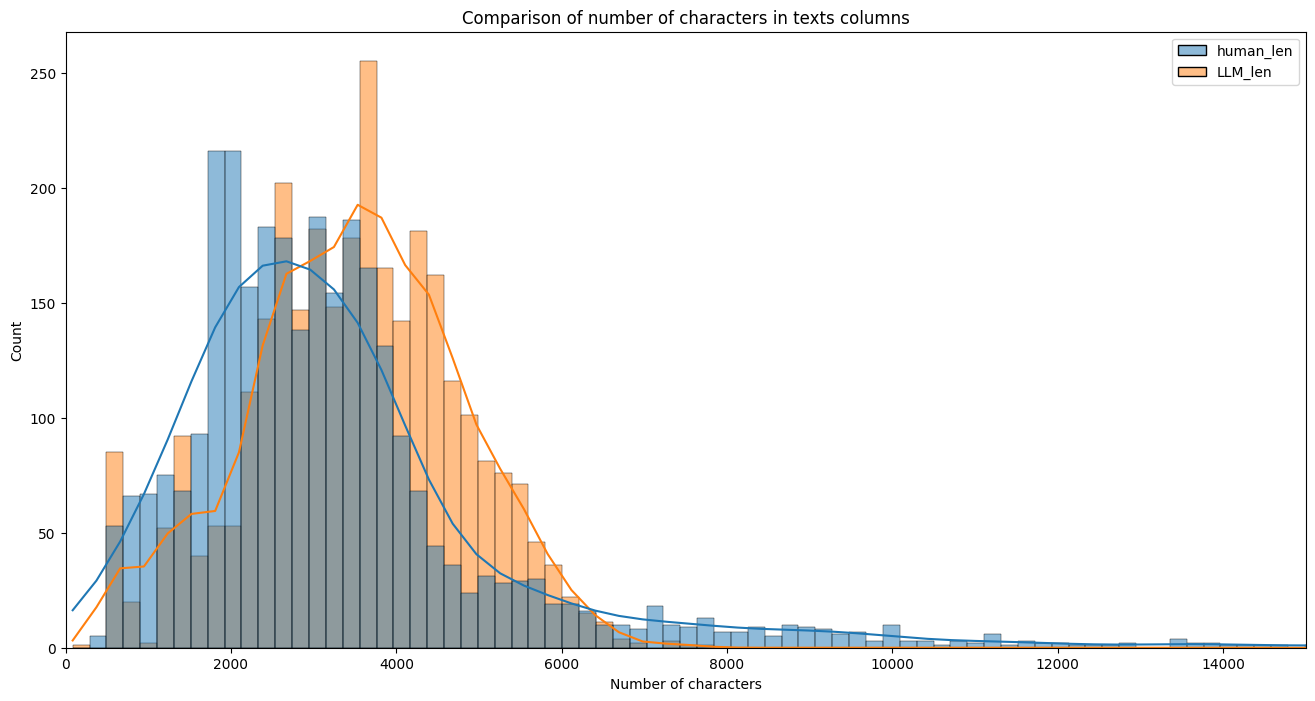

In [10]:
plt.figure(figsize=(16, 8))

sns.histplot(data=df[['human_len', 'LLM_len']], kde=True)

plt.xlim((0, 15000))

plt.xlabel('Number of characters')
plt.title('Comparison of number of characters in texts columns')
# plt.legend()

plt.show()

Human texts curve is very similar to normall bell curve but have much longer right tail (because of maximum of 57256). Now let's plot the same distribution but with no limitation on the x-axis

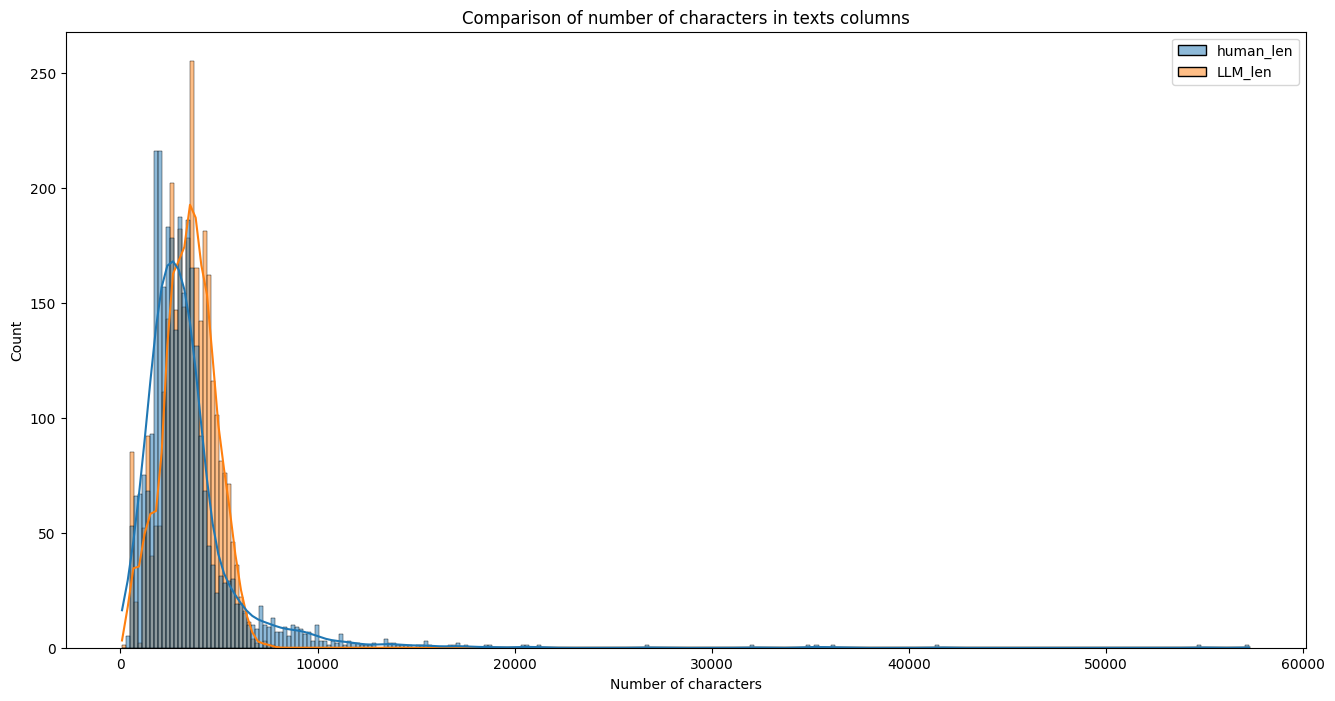

In [11]:
plt.figure(figsize=(16, 8))

sns.histplot(data=df[['human_len', 'LLM_len']], kde=True)

plt.xlabel('Number of characters')
plt.title('Comparison of number of characters in texts columns')

plt.show()

Here we can see that human text tends to be log-normally distributed.

Now let's count number of tokens using Qwen 2.5 (7b) tokenizer in order to define the appropriate `max_seq_length` to fine-tune the model

In [12]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("unsloth/Qwen2.5-7B")

tokenizer_config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

In [13]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

instruction_prompt = "Rewrite the given AI-generated text to make it sound more human-like, improving fluency, coherence, and naturalness while preserving the original meaning."

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    inputs       = examples["LLM"]
    outputs      = examples["human"]
    texts = []
    for input_, output in zip(inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction_prompt, input_, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

In [18]:
df['alpaca'] = formatting_prompts_func(df)['text']

In [19]:
from tqdm import tqdm

tqdm.pandas()

# Tokenize with progress bar
df["human_token_length"] = df["human"].progress_apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
df["LLM_token_length"] = df["LLM"].progress_apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))

df["alpaca_token_length"] = df["alpaca"].progress_apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))

100%|██████████| 3000/3000 [00:20<00:00, 146.76it/s]


Let's describe token length

In [20]:
df[['human_token_length', 'LLM_token_length', 'alpaca_token_length']].describe()

,human_token_length,LLM_token_length,alpaca_token_length
count,3000.000000,3000.000000,3000.000000
mean,723.828000,650.216333,1441.054000
std,581.725413,247.814774,710.090674
min,76.000000,21.000000,295.000000
25%,421.750000,468.000000,1075.000000
50%,625.000000,644.500000,1349.000000
75%,811.000000,790.000000,1623.250000
max,11264.000000,1674.000000,11754.000000


Mean of number of tokens is 1441, so 1024 would be not enough, so let's calculate percentile of rows that are less than 2048

In [23]:
# Calculate percentage of rows with num_tokens < 2048
percentile = (df['alpaca_token_length'] < 2048).mean() * 100

print(f"Percentile of rows with less than 2048 tokens: {percentile:.2f}%")

Percentile of rows with less than 2048 tokens: 87.80%


Because there are only 12.2% of rows that equal or greater than 2048 we can choose `max_seq_length` of 2048

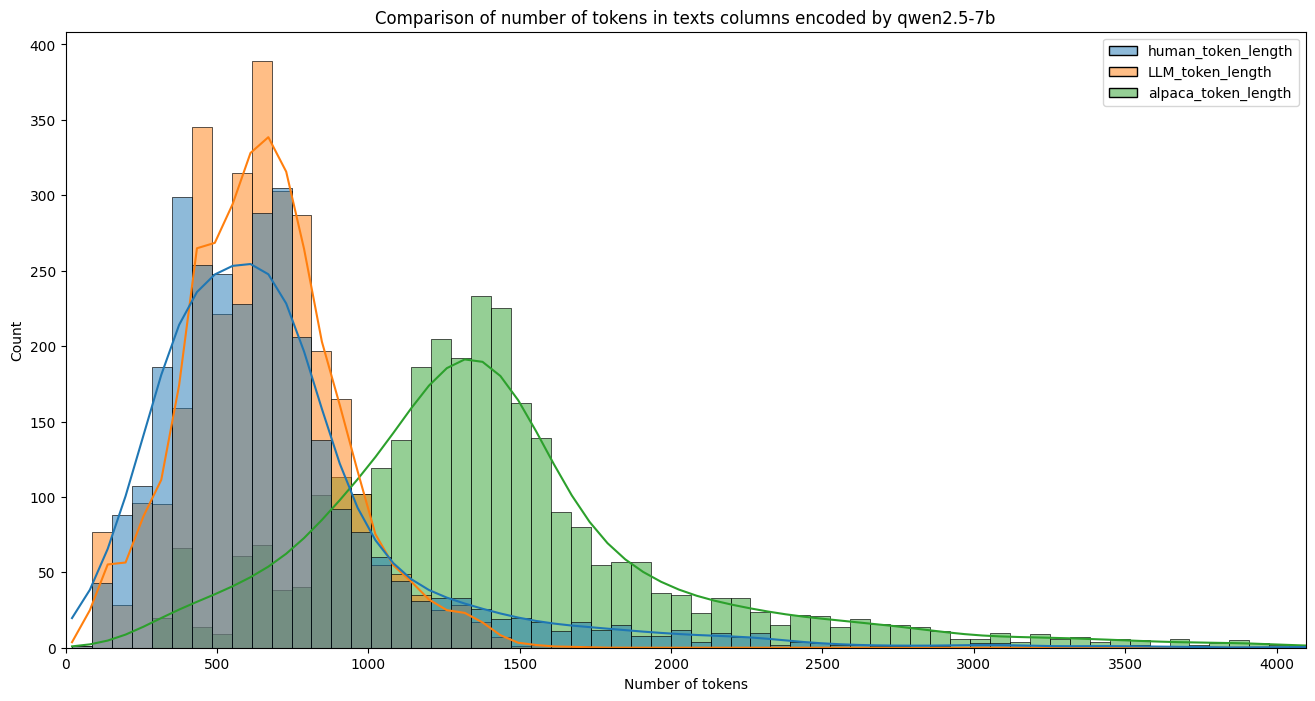

In [21]:
plt.figure(figsize=(16, 8))

sns.histplot(data=df[['human_token_length', 'LLM_token_length', 'alpaca_token_length']], kde=True)

plt.xlim((0, 4096))

plt.xlabel('Number of tokens')
plt.title('Comparison of number of tokens in texts columns encoded by qwen2.5-7b')

plt.show()

Here is the same situation as with number of characters: `human_token_length` has heavier tail.

The full number of tokens (in alpace format) also tends to be log-normally distributed

# **Wordcloud**

Let's build wordcloud for human and LLM-generated text

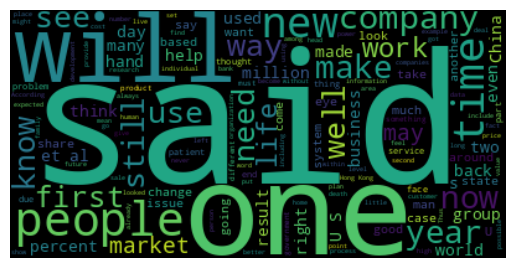

In [40]:
# Create and generate a word cloud image:
human_text = " ".join(text for text in df['human'])
wordcloud = WordCloud().generate(human_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We can see that the most frequent words are: said, will, one

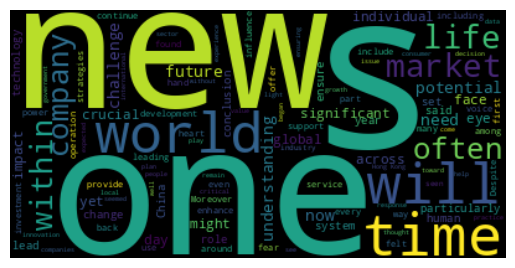

In [42]:
# Create and generate a word cloud image:
llm_text = " ".join(text for text in df['LLM'])
wordcloud = WordCloud().generate(llm_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In LLM-generated texts the most frequent words are: new, one and for some reason "s" 

# **Conclusion**

* There is always a blank line between paragraphs in LLM-generated text and this text
* LLM-generated is much more readable but also obviously artificial
* Because there are only 12.2% of rows that equal or greater than 2048 we can choose `max_seq_length` of 2048
* The most frequent words in human texts are: said, will, one
* The most frequent words in LLM-generated texts are: new, one, s